In [11]:
import numpy as np
import pandas as pd
import math
from math import factorial
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import sklearn
from sklearn.model_selection import train_test_split
import lightgbm
from lightgbm import LGBMClassifier
import catboost
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

In [13]:
sym_severity = pd.read_csv('Symptom-severity.csv')
di_sym = pd.read_csv('dataset.csv')
di_desc = pd.read_csv('symptom_Description.csv')
di_prec = pd.read_csv('symptom_precaution.csv')

In [14]:
print(di_sym.head())

            Disease   Symptom_1              Symptom_2              Symptom_3  \
0  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
1  Fungal infection   skin_rash   nodal_skin_eruptions    dischromic _patches   
2  Fungal infection     itching   nodal_skin_eruptions    dischromic _patches   
3  Fungal infection     itching              skin_rash    dischromic _patches   
4  Fungal infection     itching              skin_rash   nodal_skin_eruptions   

              Symptom_4 Symptom_5 Symptom_6 Symptom_7 Symptom_8 Symptom_9  \
0   dischromic _patches       NaN       NaN       NaN       NaN       NaN   
1                   NaN       NaN       NaN       NaN       NaN       NaN   
2                   NaN       NaN       NaN       NaN       NaN       NaN   
3                   NaN       NaN       NaN       NaN       NaN       NaN   
4                   NaN       NaN       NaN       NaN       NaN       NaN   

  Symptom_10 Symptom_11 Symptom_12 Symptom_13 Symp

In [15]:
symptoms = list(sym_severity['Symptom'].unique())
diseases = list(di_sym['Disease'].unique())

In [16]:
mat = np.zeros((len(di_sym), len(symptoms)+1))

for i in range(len(di_sym)):
    mat[i,0] = diseases.index(di_sym.iloc[i,0])
    j = 1
    for j in range(1, 18):
        if di_sym.iloc[i,j] is not np.nan:
            sym_idx = symptoms.index(di_sym.iloc[i,j].replace(' ',''))
            mat[i,sym_idx+1] = 1    

symptoms_li = symptoms.copy()
symptoms_li.insert(0, 'Disease')      
di_sym_df = pd.DataFrame(mat, columns = symptoms_li)

In [17]:
train_df, test_df = train_test_split(di_sym_df, test_size = 0.1, stratify=di_sym_df['Disease'], random_state=2022)

In [18]:
print('there are {} symptoms described in the dataset'.format(len(symptoms)))
print('there are {} diseases described in the dataset'.format(len(diseases)))

there are 132 symptoms described in the dataset
there are 41 diseases described in the dataset


In [19]:
adj_mat = np.zeros((133,41))
for i in range(len(di_sym)):
    for j in range(1, 18):
        disease = di_sym.iloc[i,0]
        symptom = di_sym.iloc[i,j]
        if pd.notnull(symptom):
            symptom = symptom.replace(' ','')
            dis_index = diseases.index(disease)
            sym_index = symptoms.index(symptom)
            adj_mat[sym_index, dis_index] += 1
        else:
            pass

Text(0, 0.5, 'symptom')

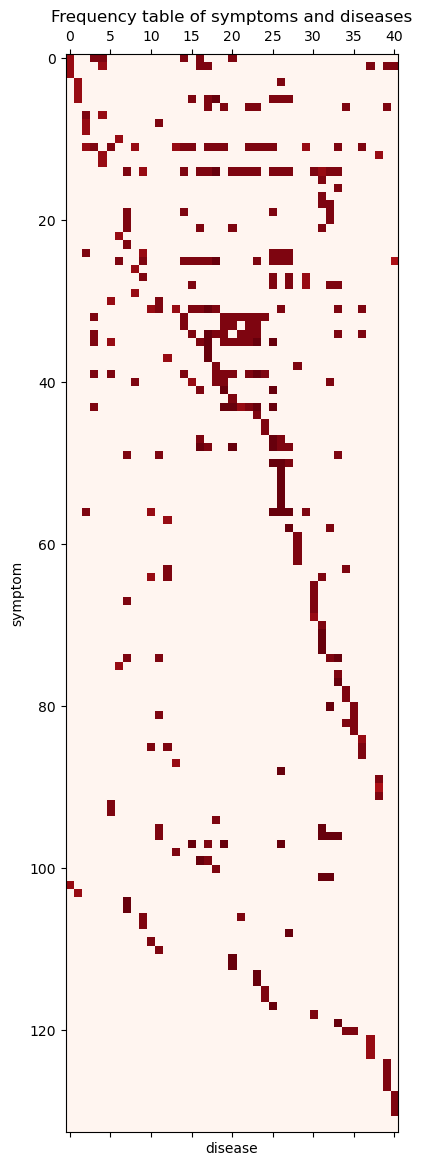

In [20]:
fig = plt.figure(figsize=(7,14))
ax = fig.add_subplot()
ax.matshow(adj_mat, cmap='Reds')
ax.set_title('Frequency table of symptoms and diseases')
ax.set_xlabel('disease')
ax.set_ylabel('symptom')

Text(0.5, 1.0, 'Probability distribution of diseases')

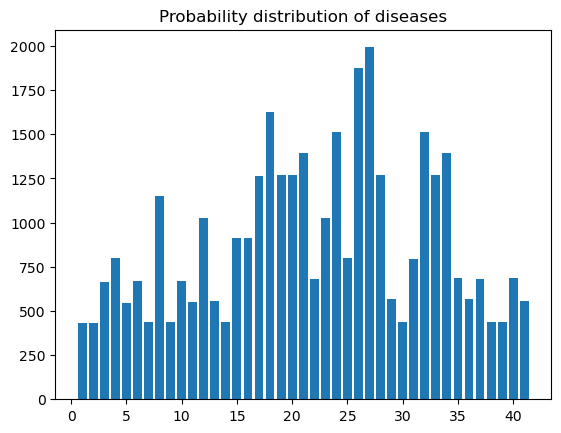

In [21]:
plt.bar(np.arange(1,42),adj_mat.sum(axis=0))
plt.title('Probability distribution of diseases')

Text(0.5, 1.0, 'Probability distribution of symptoms')

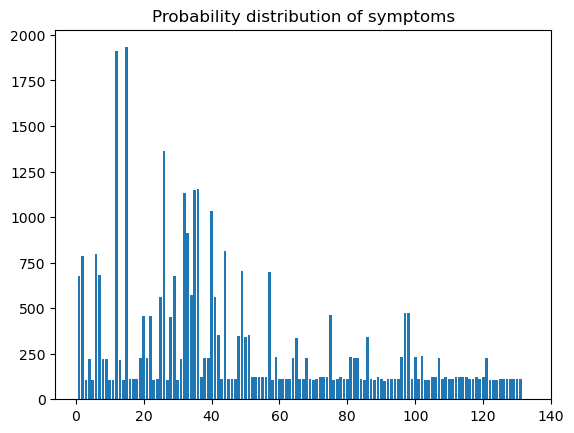

In [22]:
plt.bar(np.arange(1,134),adj_mat.sum(axis=1))
plt.title('Probability distribution of symptoms')

In [23]:
class PromptToSym(nn.Module):
    def __init__(self, symptoms_li):
        super(PromptToSym, self).__init__()
        self.tokenizer = transformers.AutoTokenizer.from_pretrained("bvanaken/CORe-clinical-outcome-biobert-v1")
        self.model = transformers.AutoModel.from_pretrained("bvanaken/CORe-clinical-outcome-biobert-v1")
        self.symptoms = symptoms_li
        self.construct_prompt()
    
    @torch.no_grad()
    def construct_prompt(self):
        sym_prompt = list(map(lambda x: 'Symptom of ' + x, self.symptoms))
        token = self.tokenizer.batch_encode_plus(sym_prompt, return_tensors='pt', truncation=True, padding=True, max_length=8)
        self.symptom_embed = self.model(**token).pooler_output
    
    @torch.no_grad()
    def forward(self, user_prompt, topk = 3):
        '''
        user_prompt : 'str'
        '''
        token = self.tokenizer.batch_encode_plus([user_prompt], return_tensors='pt', truncation=True, padding=True, max_length=8)
        out = self.model(**token).pooler_output # 1 x 768
        sim = F.cosine_similarity(self.symptom_embed, out)
        sym_idx = torch.topk(sim, topk).indices
        return np.array(self.symptoms)[sym_idx]

In [24]:
p2s = PromptToSym(symptoms)

config.json:   0%|          | 0.00/428 [00:00<?, ?B/s]

C:\Users\deepa\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\deepa\.cache\huggingface\hub\models--bvanaken--CORe-clinical-outcome-biobert-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

C:\Users\deepa\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [25]:
p2s('I have stomachache and headache', topk = 3)

array(['cold_hands_and_feets', 'small_dents_in_nails', 'redness_of_eyes'],
      dtype='<U30')

In [26]:
def doctor_bayes(adj_mat, symptom_list, symptoms, diseases):
    sym = [symptoms.index(s) for s in symptom_list]
    p_dis = adj_mat.sum(axis=0) / adj_mat.sum()
    p_sym = adj_mat.sum(axis=1) / adj_mat.sum()
    dist = []
    for i in range(41):
        # compute bayes probability
        prob = np.prod((adj_mat[:,i]/ adj_mat[:,i].sum())[sym])*p_dis[i] / np.prod(p_sym[sym])
        dist.append(prob)
    if sum(dist) == 0:
        return 'I have no Idea'
    else:
        idx = dist.index(max(dist))
        return diseases[idx]

In [27]:
doctor_bayes(adj_mat, ['fatigue', 'mood_swings'], symptoms, diseases)

'Hyperthyroidism'

In [28]:
doctor_bayes(adj_mat, ['itching', 'skin_rash'], symptoms, diseases)

'Fungal infection'

In [29]:
doctor_bayes(adj_mat, ['fatigue', 'high_fever'], symptoms, diseases)

'Bronchial Asthma'

In [30]:
doctor_bayes(adj_mat, ['fatigue', 'high_fever', 'itching', 'coma'], symptoms, diseases)

'I have no Idea'

In [31]:
X_train, y_train = train_df.iloc[:,1:], train_df.iloc[:,0].astype(str)
X_test, y_test = test_df.iloc[:,1:], test_df.iloc[:,0]

In [32]:
clf = CatBoostClassifier()
clf.fit(X_train, y_train, verbose=False)

In [33]:
y_pred = clf.predict(X_test).astype(float)
acc = (y_pred.reshape(-1,) == y_test.values).sum() / len(y_pred)

print('Accuracy : {}%'.format(acc*100))

Accuracy : 100.0%


In [34]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, di_sym_df, train = True):
        self.X_data = di_sym_df.values[:,1:]
        self.y_data = di_sym_df.values[:,0]
        self.train = train
        
    def __len__(self):
        return self.X_data.shape[0]
    
    def __getitem__(self, index):
        li = self.X_data[index,:]
        x = torch.where(torch.tensor(li) == 1)[0]
        x = torch.cat([x, torch.ones(17-x.shape[0])*132], )
        if self.train:
            y = self.y_data[index]
            return x.to(int), y.astype(int)
        else:
            return x

In [35]:
class EmbeddingModel1(nn.Module):
    def __init__(self, symptoms, diseases, h_dim=2):
        super(EmbeddingModel1, self).__init__()
        # assign feature to Embedding layer parameter
        self.S = nn.Embedding(len(symptoms)+1, h_dim)
        self.D = nn.Embedding(len(diseases), h_dim)
        with torch.no_grad():
            self.S.weight[-1,:] = torch.zeros(h_dim, requires_grad=False)
    
    def forward(self, sym_idx, dis_idx):
        x = self.S(sym_idx) # batch_size x k x h_dim
        x = torch.mean(x, dim=1)
        y = self.D(dis_idx) # batch_size x h_dim
        sim = torch.matmul(x / x.norm(dim=1).unsqueeze(1), (y / y.norm(dim=1).unsqueeze(1)).t())
        return sim

1th epoch end
2th epoch end
3th epoch end
4th epoch end
5th epoch end
6th epoch end
7th epoch end
8th epoch end
9th epoch end
10th epoch end
11th epoch end
12th epoch end
13th epoch end
14th epoch end
15th epoch end
16th epoch end
17th epoch end
18th epoch end
19th epoch end
20th epoch end
21th epoch end
22th epoch end
23th epoch end
24th epoch end
25th epoch end
26th epoch end
27th epoch end
28th epoch end
29th epoch end
30th epoch end
31th epoch end
32th epoch end
33th epoch end
34th epoch end
35th epoch end
36th epoch end
37th epoch end
38th epoch end
39th epoch end
40th epoch end
41th epoch end
42th epoch end
43th epoch end
44th epoch end
45th epoch end
46th epoch end
47th epoch end
48th epoch end
49th epoch end
50th epoch end
51th epoch end
52th epoch end
53th epoch end
54th epoch end
55th epoch end
56th epoch end
57th epoch end
58th epoch end
59th epoch end
60th epoch end
61th epoch end
62th epoch end
63th epoch end
64th epoch end
65th epoch end
66th epoch end
67th epoch end
68th

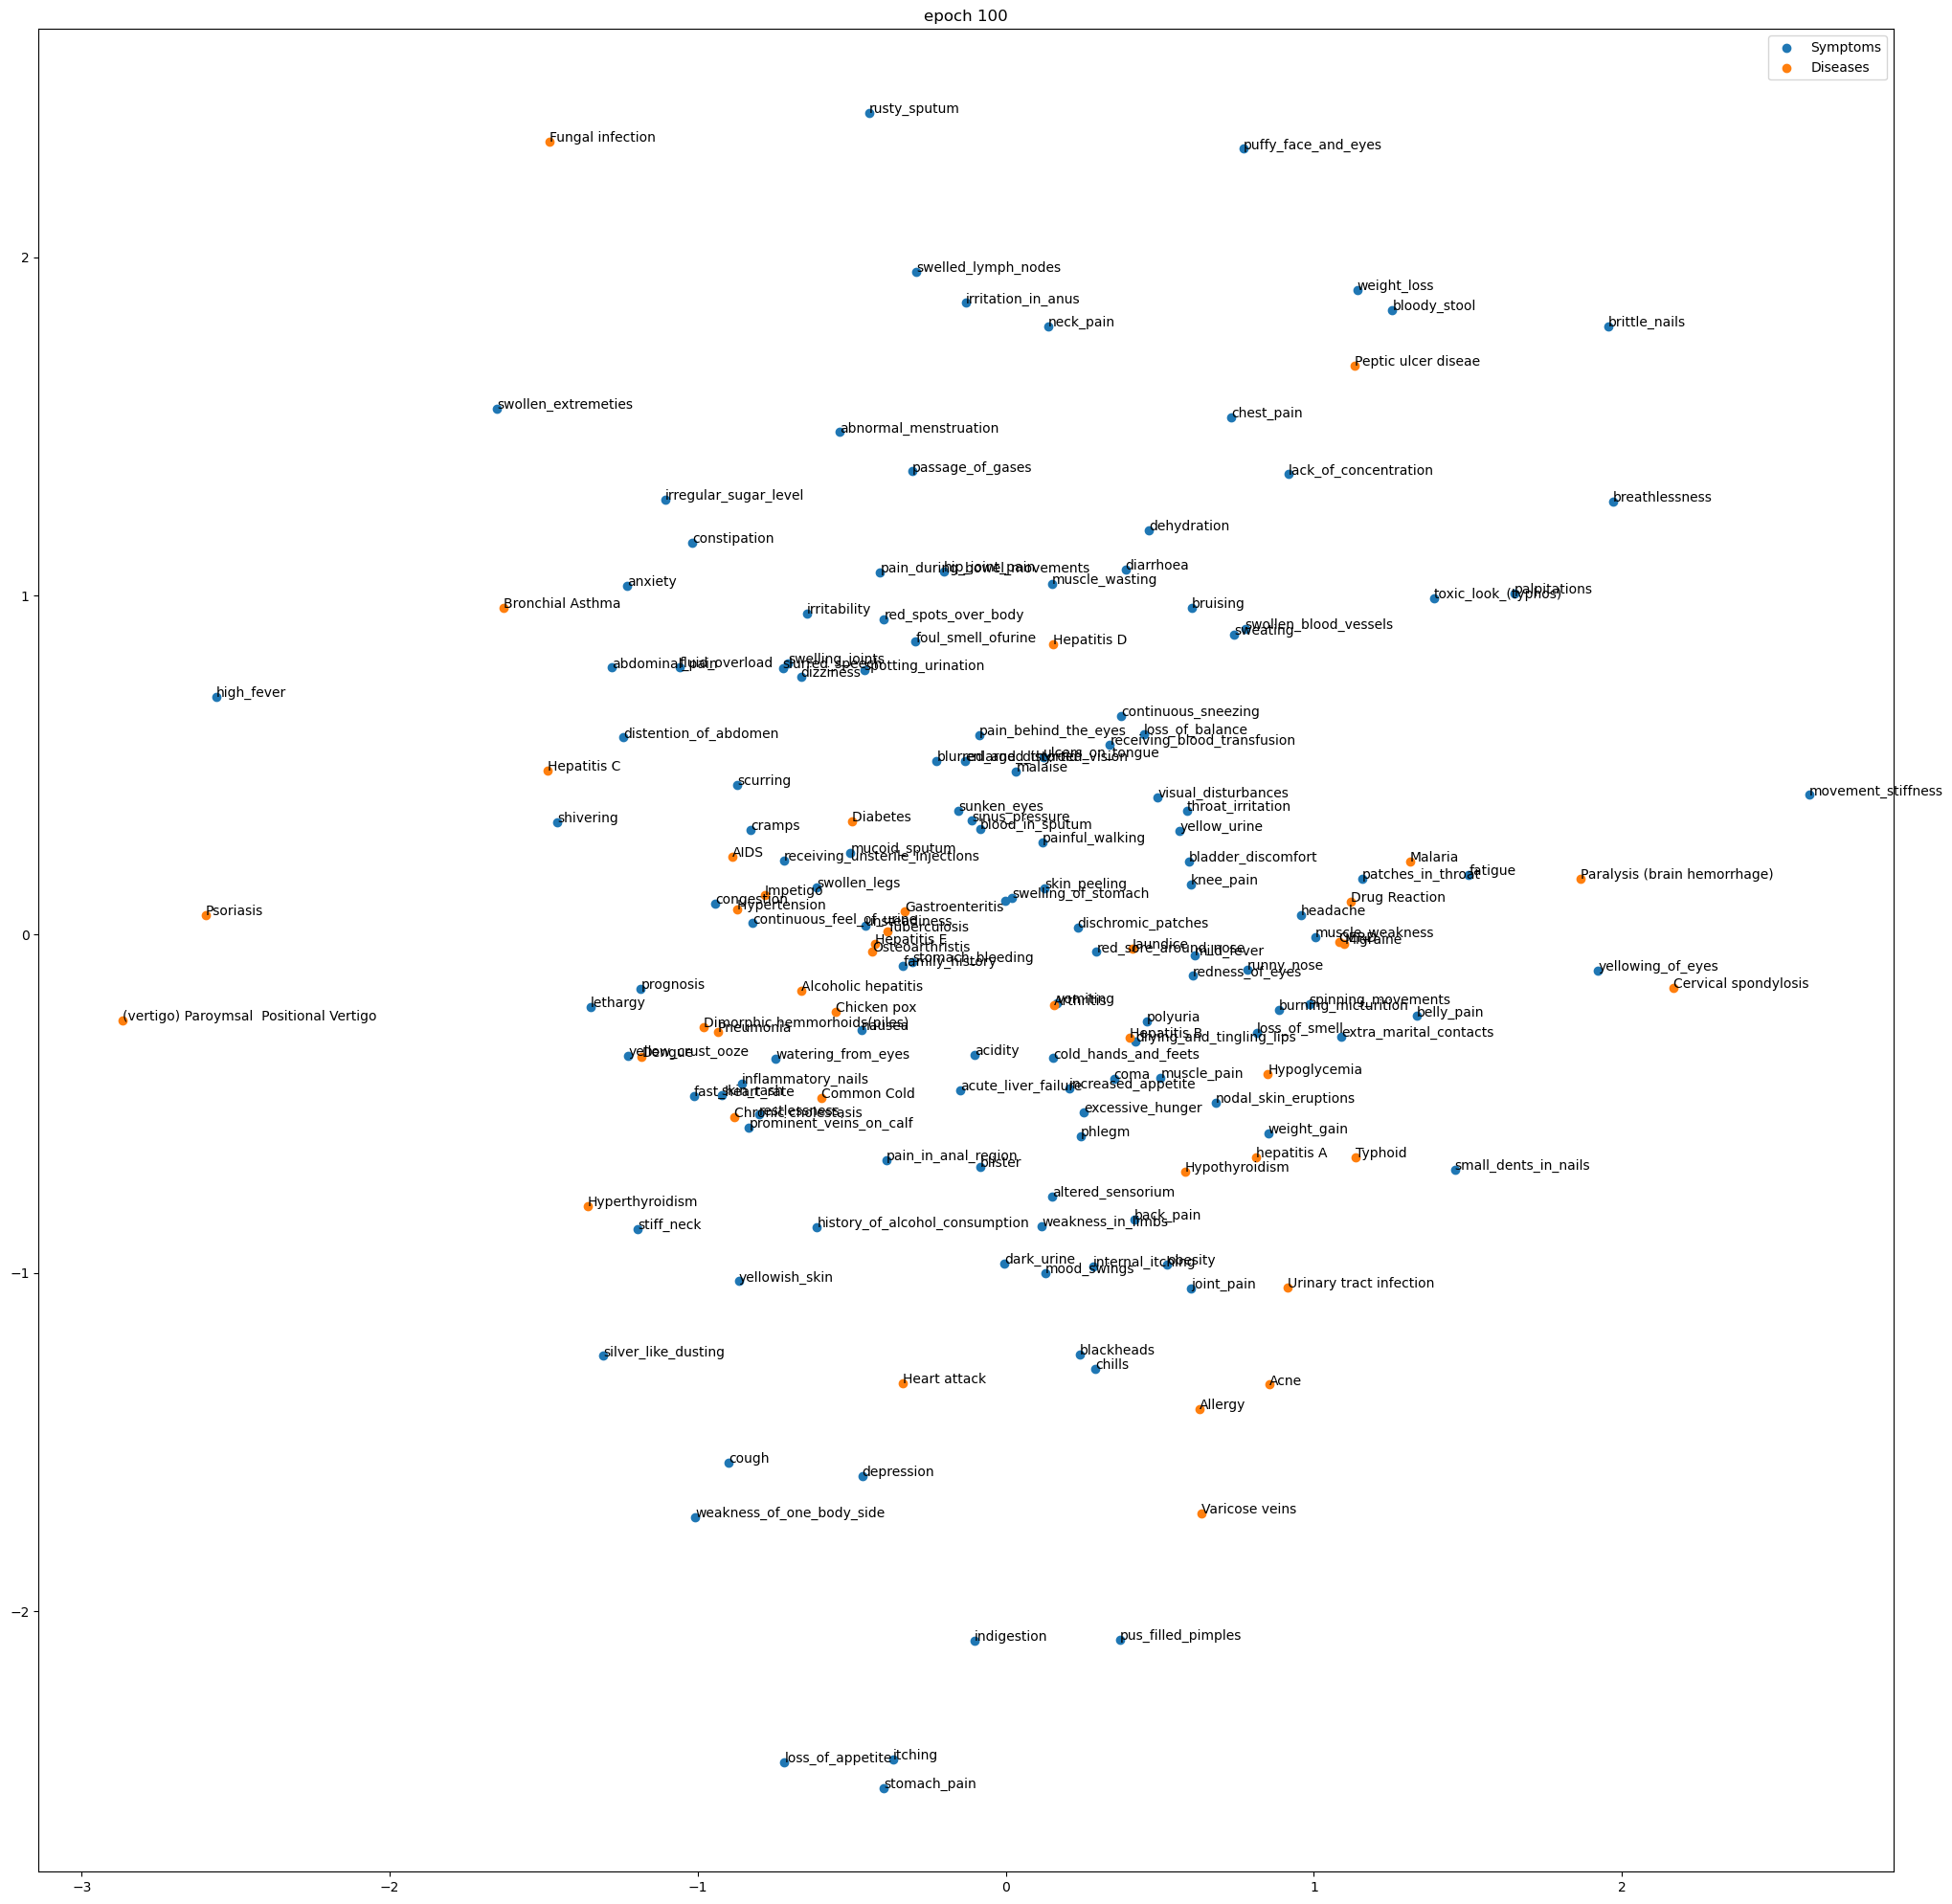

In [38]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming you have defined Dataset and EmbeddingModel1 properly.

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
n_epochs = 100
criterion = nn.CrossEntropyLoss()

# Create dataset and dataloader
data = Dataset(train_df)
dataloader = torch.utils.data.DataLoader(data, batch_size=len(train_df), shuffle=True)

# Initialize the model, optimizer, and criterion
model = EmbeddingModel1(symptoms, diseases, h_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(n_epochs):
    for step, (X, y) in enumerate(dataloader):
        # Ensure labels are of Long type for CrossEntropyLoss
        y = y.long()

        # Forward pass
        sim = model(X, y)

        # Calculate loss
        loss = criterion(sim, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Print epoch end message
    print(f'{epoch + 1}th epoch end')

# Visualize embeddings after training
plt.scatter(model.S.weight[:, 0].detach(), model.S.weight[:, 1].detach(), label="Symptoms")
plt.scatter(model.D.weight[:, 0].detach(), model.D.weight[:, 1].detach(), label="Diseases")

# Annotate symptoms and diseases
for i, sn in enumerate(symptoms):
    plt.text(model.S.weight[:, 0].detach()[i], model.S.weight[:, 1].detach()[i], sn)
for i, dn in enumerate(diseases):
    plt.text(model.D.weight[:, 0].detach()[i], model.D.weight[:, 1].detach()[i], dn)

# Add title and show plot
plt.title(f'epoch {epoch + 1}')
plt.legend()
plt.show()


In [39]:
class EmbeddingModel2(nn.Module):
    def __init__(self, symptoms, diseases):
        super(EmbeddingModel, self).__init__()
        sym_prompt = list(map(lambda x: 'Symptom of ' + x, symptoms))
        dis_prompt = list(map(lambda x: 'Disease of ' + x, diseases))
        tokenizer = transformers.AutoTokenizer.from_pretrained("bvanaken/CORe-clinical-outcome-biobert-v1")
        biobert = transformers.AutoModel.from_pretrained("bvanaken/CORe-clinical-outcome-biobert-v1")
        # tokenize
        sym_token = tokenizer.batch_encode_plus(sym_prompt, return_tensors='pt', truncation=True, padding=True, max_length=8)
        dis_token = tokenizer.batch_encode_plus(dis_prompt, return_tensors='pt', truncation=True, padding=True, max_length=8)
        # extract symptom feature, disease feature using pretrained BioBERT
        with torch.no_grad():
            sym_mat = biobert(**sym_token).pooler_output
            dis_mat = biobert(**dis_token).pooler_output
        # assign feature to Embedding layer parameter
        self.S = nn.Embedding(len(symptoms), 768)
        self.D = nn.Embedding(len(symptoms), 768)
        self.S.weight = sym_mat
        self.D.weight = dis_mat
    
    def forward(self, sym_idx, dis_idx):
        x = self.S(sym_idx) # batch_size x k x 768
        x = torch.mean(x, dim=1)
        y = self.D(dis_idx) # batch_size x 768
        sim = torch.matmul(x, )

In [40]:
p2s('I have stomachache and headache', topk = 3)

array(['cold_hands_and_feets', 'small_dents_in_nails', 'redness_of_eyes'],
      dtype='<U30')

In [41]:
doctor_bayes(adj_mat, ['stomach_pain', 'mood_swings'], symptoms, diseases)

'I have no Idea'

In [44]:
doctor_bayes(adj_mat, ['vomiting', 'high_fever'], symptoms, diseases)

'Jaundice'